# Анализ временных рядов занятости в индустрии гостеприимства Калифорнии

## Цели ЛР:
- Предварительный анализ и визуализация данных
- Проверка стационарности временного ряда
- Построение модели прогнозирования
- Анализ и интерпретация результатов

In [ ]:
# Ячейка 1: импорты и базовые настройки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 5)


## Загрузка и первичный обзор данных

На этом этапе:
- загрузка временного ряда данных о занятости;
- первичная визуализация для выявления тренда, сезонных колебаний и возможных аномалий.

Структура данных:


,Employees
Date,
1990-01-01,1064.5
1990-02-01,1074.5
1990-03-01,1090.0
1990-04-01,1097.4
1990-05-01,1108.7


Всего наблюдений: 348


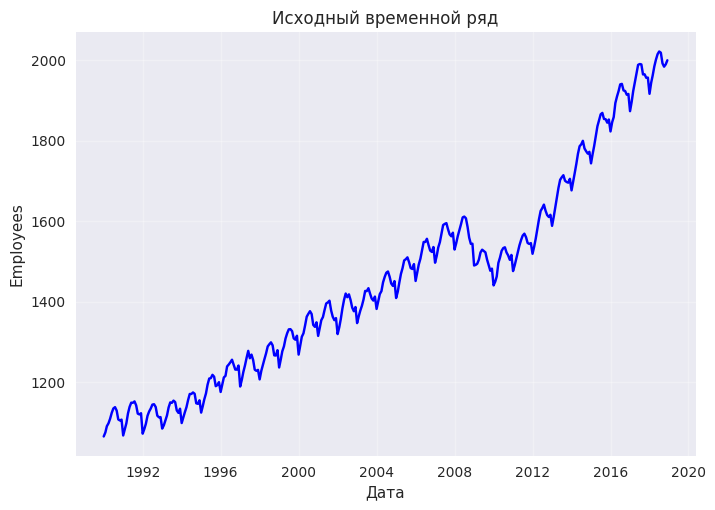

In [24]:
# Ячейка 2: загрузка данных и первичный обзор
df = pd.read_csv("lab5.csv")   # замените на свой файл, если нужно
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df = df.set_index('Date')

print("Структура данных:")
display(df.head())
print(f"Всего наблюдений: {len(df)}")

# визуализация исходного временного ряда
plt.figure()
plt.plot(df.index, df['Employees'], color='blue')
plt.title("Исходный временной ряд")
plt.xlabel("Дата")
plt.ylabel("Employees")
plt.grid(alpha=0.3)
plt.show()


Видим около 2010 какую то просадку которую мы предсказать не можем

## 3. Разделение данных на train/validation/test

Train: 278, Validation: 34, Test: 36


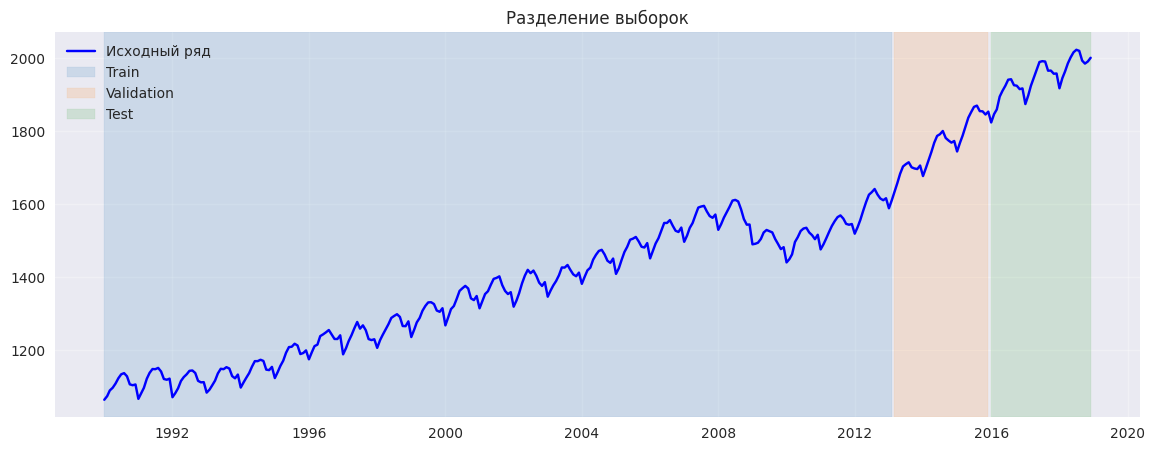

In [25]:
# Ячейка 3: безопасное разбиение по позициям
def time_series_split_by_pos(df, train_ratio=0.8, val_ratio=0.1):
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    train = df.iloc[:train_end].copy()
    val = df.iloc[train_end:val_end].copy()
    test = df.iloc[val_end:].copy()
    return train, val, test

train, validation, test = time_series_split_by_pos(df)

print(f"Train: {len(train)}, Validation: {len(validation)}, Test: {len(test)}")

# добавим индексы для визуализации и анализа
df_plot = df.copy()
df_plot['Dataset'] = 'Test'
df_plot.iloc[:len(train), df_plot.columns.get_loc('Dataset')] = 'Train'
df_plot.iloc[len(train):len(train)+len(validation), df_plot.columns.get_loc('Dataset')] = 'Validation'

df_plot['Month_num'] = np.arange(len(df_plot))
train['Month_num'] = df_plot['Month_num'].iloc[:len(train)].values
validation['Month_num'] = df_plot['Month_num'].iloc[len(train):len(train)+len(validation)].values
test['Month_num'] = df_plot['Month_num'].iloc[len(train)+len(validation):].values

# визуализация разбиения
plt.figure(figsize=(14,5))
plt.plot(df_plot.index, df_plot['Employees'], color='blue', label='Исходный ряд')
plt.axvspan(train.index[0], train.index[-1], color='tab:blue', alpha=0.15, label='Train')
plt.axvspan(validation.index[0], validation.index[-1], color='tab:orange', alpha=0.15, label='Validation')
plt.axvspan(test.index[0], test.index[-1], color='tab:green', alpha=0.15, label='Test')
plt.title("Разделение выборок")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Тренд (MA12) и сезонность

## Выделение тренда и сезонности

Далее анализируем временной ряд детальнее:
- рассчитываем скользящее среднее (`MA12`) для выявления долгосрочного тренда;
- оцениваем сезонную компоненту, усредняя остатки по месяцам;
- визуализируем обе составляющие.

**Цель:** разложить ряд на тренд, сезонность и остаточную часть, чтобы использовать их при моделировании.


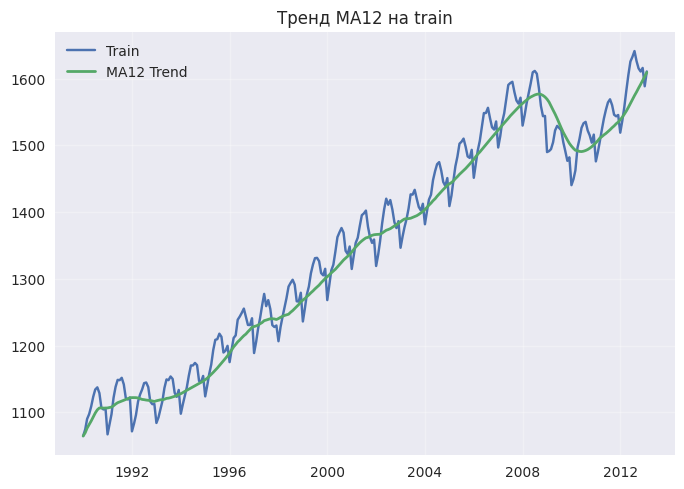

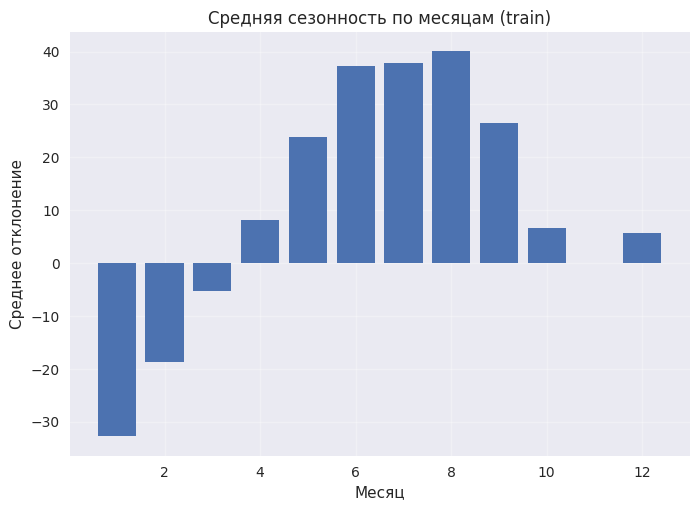

In [42]:
# Ячейка 4: тренд и сезонность (на train)
window = 12
train['ma12_trend'] = train['Employees'].rolling(window=window, min_periods=1).mean()

# экстраполяция тренда на валидацию и тест
last_n = min(12, len(train))
last_vals = train['ma12_trend'].iloc[-last_n:].values
last_idx = train['Month_num'].iloc[-last_n:].values
slope = np.polyfit(last_idx, last_vals, 1)[0] if len(last_vals) >= 2 else 0
last_ma = train['ma12_trend'].iloc[-1]
validation['ma12_trend'] = last_ma + slope * (validation['Month_num'] - train['Month_num'].iloc[-1])
test['ma12_trend'] = last_ma + slope * (test['Month_num'] - train['Month_num'].iloc[-1])

# сезонность по train
train['resid_temp'] = train['Employees'] - train['ma12_trend']
seasonal_profile = train['resid_temp'].groupby(train.index.month).mean().reindex(range(1,13)).fillna(0)
train['seasonal'] = train.index.month.map(seasonal_profile)
validation['seasonal'] = validation.index.month.map(seasonal_profile)
test['seasonal'] = test.index.month.map(seasonal_profile)

# визуализация тренда и сезонности
plt.figure()
plt.plot(train.index, train['Employees'], label='Train')
plt.plot(train.index, train['ma12_trend'], label='MA12 Trend', linewidth=2)
plt.title("Тренд MA12 на train")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure()
plt.bar(range(1,13), seasonal_profile)
plt.title("Средняя сезонность по месяцам (train)")
plt.xlabel("Месяц")
plt.ylabel("Среднее отклонение")
plt.grid(alpha=0.3)
plt.show()


## Модель AR на остатках и прогноз

## Проверка стационарности и моделирование остатков

После выделения тренда и сезонности проверяем остатки ряда на стационарность.

**Почему важно:**  
Модель ARIMA требует стационарности. Если остатки нестационарны, выполняются преобразования (разности, логарифмы и т. д.).  

Здесь:
- остатки после удаления тренда и сезонности проверяются визуально;
- для стационарных остатков строится модель авторегрессии (AR) — первая версия модели, объясняющая внутренние зависимости.


                               SARIMAX Results                                
Dep. Variable:              residuals   No. Observations:                  278
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -837.912
Date:                Fri, 07 Nov 2025   AIC                           1683.825
Time:                        00:21:29   BIC                           1698.335
Sample:                    01-01-1990   HQIC                          1689.646
                         - 02-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1450      4.514      0.697      0.486      -5.702      11.992
ar.L1          0.8905      0.065     13.683      0.000       0.763       1.018
ar.L2          0.0566      0.069      0.824      0.4

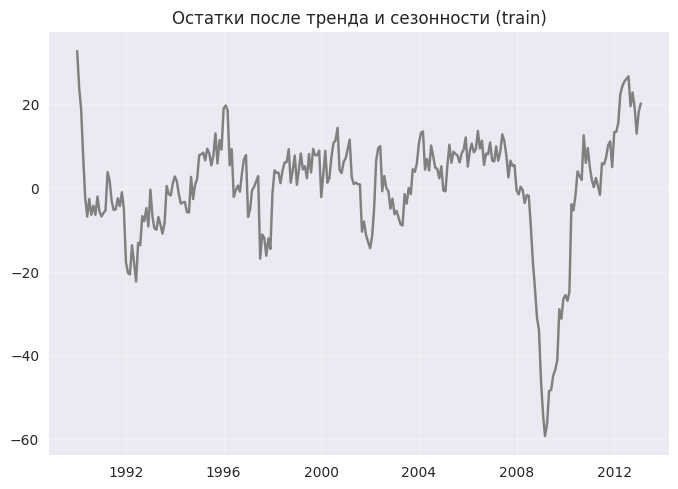

In [27]:
# Ячейка 5: AR(2) на остатках
train['residuals'] = train['Employees'] - train['ma12_trend'] - train['seasonal']
resid_train = train['residuals'].dropna()

ar_model = ARIMA(resid_train, order=(2,0,0)).fit()
print(ar_model.summary())

# прогноз остатков
resid_forecast_val = ar_model.forecast(steps=len(validation))
resid_forecast_val.index = validation.index
resid_forecast_test = ar_model.forecast(steps=len(validation) + len(test))[len(validation):]
resid_forecast_test.index = test.index

# визуализация остатков
plt.figure()
plt.plot(train.index, resid_train, color='gray')
plt.title("Остатки после тренда и сезонности (train)")
plt.grid(alpha=0.3)
plt.show()


## Сборка трёх моделей и оценка на валидации

## Построение базовых моделей прогнозирования

На основе выделенных компонент создаются три модели:
1. **Simple** — тренд + сезонность  
2. **Medium** — тренд + сезонность + авторегрессия (AR)  
3. **Complex** — та же структура, но AR обучается с кросс-валидацией

**Этапы:**
- строим прогнозы на валидационной выборке;
- сравниваем качество по метрикам RMSE и MAE;
- визуализируем, как модели воспроизводят динамику валидационных данных.


Validation simple: RMSE=40.71, MAE=39.98, R2=0.615
Validation medium: RMSE=30.99, MAE=29.03, R2=0.777


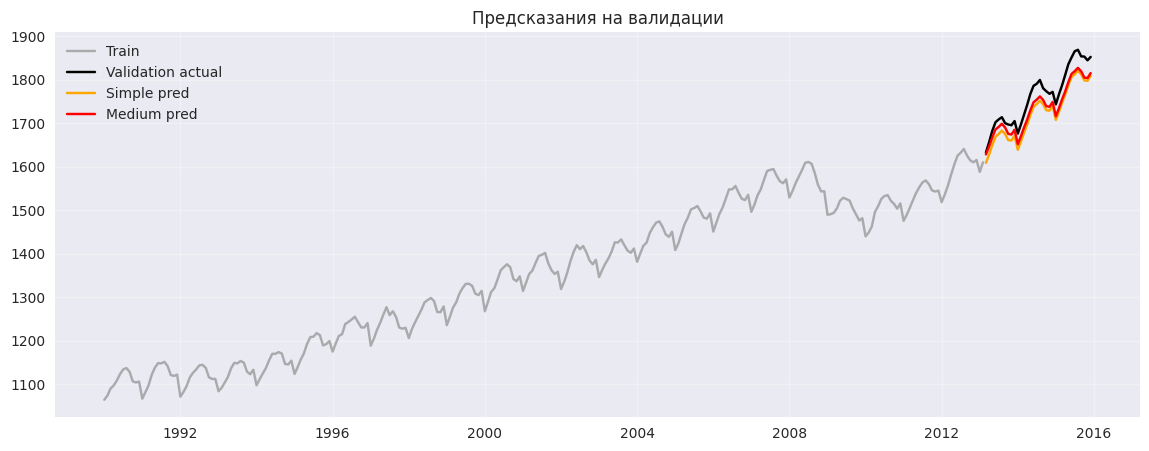

In [28]:
# Ячейка 6: три модели
validation['pred_simple'] = validation['ma12_trend'] + validation['seasonal']
validation['pred_medium'] = validation['ma12_trend'] + validation['seasonal'] + resid_forecast_val
validation['pred_complex'] = validation['pred_medium']  # временно, до CV

def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

for m in ['simple', 'medium']:
    rmse, mae, r2 = metrics(validation['Employees'], validation[f'pred_{m}'])
    print(f"Validation {m}: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.3f}")

# визуализация предсказаний на validation
plt.figure(figsize=(14,5))
plt.plot(train.index, train['Employees'], color='gray', alpha=0.6, label='Train')
plt.plot(validation.index, validation['Employees'], color='black', label='Validation actual')
plt.plot(validation.index, validation['pred_simple'], color='orange', label='Simple pred')
plt.plot(validation.index, validation['pred_medium'], color='red', label='Medium pred')
plt.title("Предсказания на валидации")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Кросс-валидация для AR (сложная модель)

Количество фолдов для CV: 21
✅ CV успешно рассчитана, обновлено 34 точек валидации.


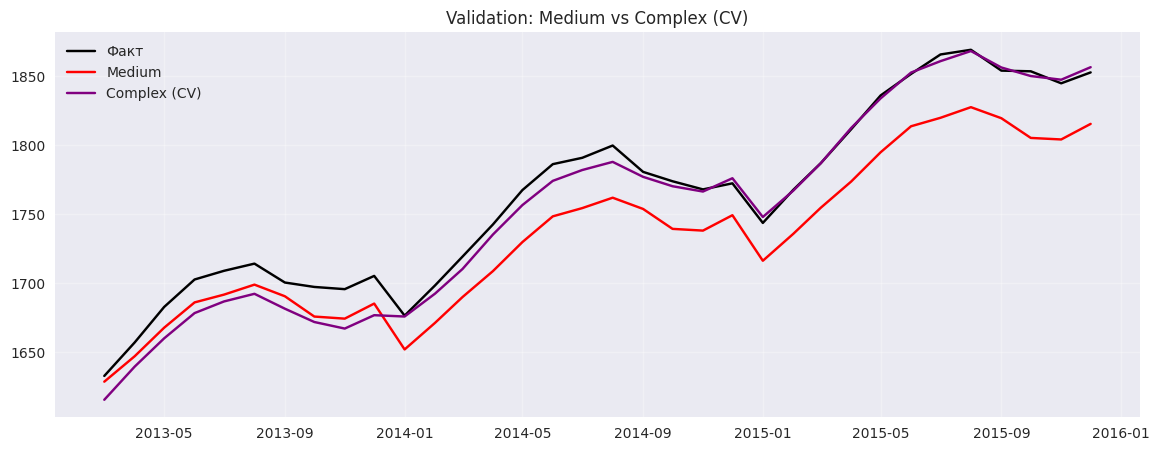

In [32]:
# Ячейка 7: скользящая CV для AR (train+validation)
full_for_cv = pd.concat([train, validation])
window = 60   # длина обучающего окна (месяцев)
step = 12     # шаг сдвига (месяцев)
cv_forecasts_val = []

starts = list(range(0, len(full_for_cv) - window - step + 1, step))
print(f"Количество фолдов для CV: {len(starts)}")

for s in starts:
    tr = full_for_cv.iloc[s:s+window].copy()
    te = full_for_cv.iloc[s+window:s+window+step].copy()

    # тренд и сезонность на фолде
    tr['ma12_trend'] = tr['Employees'].rolling(12, min_periods=1).mean()
    tr['resid'] = tr['Employees'] - tr['ma12_trend']
    seas_prof = tr['resid'].groupby(tr.index.month).mean().reindex(range(1,13)).fillna(0)
    te['seasonal'] = te.index.month.map(seas_prof)
    tr['resid_final'] = tr['Employees'] - tr['ma12_trend'] - tr.index.month.map(seas_prof)
    resid = tr['resid_final'].dropna()

    if len(resid) < 5:
        continue

    try:
        # обучаем AR
        model_cv = ARIMA(resid, order=(2,0,0)).fit()
        resid_pred = model_cv.forecast(steps=len(te))

        # экстраполяция тренда на фолд
        ma_nonan = tr['ma12_trend'].dropna()
        last_n = min(12, len(ma_nonan))
        if last_n >= 2:
            last_vals = ma_nonan.iloc[-last_n:].values
            last_idx = np.arange(last_n)
            slope = np.polyfit(last_idx, last_vals, 1)[0]
        else:
            slope = 0
        last_ma = ma_nonan.iloc[-1]
        months = np.arange(1, len(te)+1)
        trend_extr = last_ma + slope * months

        # финальный прогноз фолда
        pred_fold = trend_extr + te['seasonal'].values + resid_pred.values
        pred_series = pd.Series(pred_fold, index=te.index)

        # если этот фолд пересекается с validation — сохраняем
        val_overlap = validation.index.intersection(pred_series.index)
        if len(val_overlap) > 0:
            cv_forecasts_val.append(pred_series.loc[val_overlap])
    except Exception as e:
        # отладка — покажем первые 2 ошибки
        if s < starts[0] + 2*step:
            print(f"Фолд {s}: ошибка {e}")
        continue

# усредняем прогнозы
if len(cv_forecasts_val) > 0:
    cv_df = pd.concat(cv_forecasts_val, axis=1)
    cv_mean = cv_df.mean(axis=1)
    validation.loc[cv_mean.index, 'pred_complex'] = cv_mean
    print(f"✅ CV успешно рассчитана, обновлено {len(cv_mean)} точек валидации.")
else:
    print("⚠️ CV не дала прогнозов (ни один фолд не перекрыл validation).")

# Визуализация CV-прогнозов
plt.figure(figsize=(14,5))
plt.plot(validation.index, validation['Employees'], color='black', label='Факт')
plt.plot(validation.index, validation['pred_medium'], color='red', label='Medium')
plt.plot(validation.index, validation['pred_complex'], color='purple', label='Complex (CV)')
plt.title("Validation: Medium vs Complex (CV)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Финальный прогноз на test (train+validation)

## Финальный прогноз на тестовых данных

После подбора параметров на валидации выполняется итоговое обучение:
- объединяем `train + validation` → формируем `train_full`;
- переоцениваем тренд, сезонность и остатки;
- строим прогноз на тестовый период.

**Важно:**  
На этом этапе модель больше не проверяется — прогноз выполняется на данных, которые не использовались при обучении.


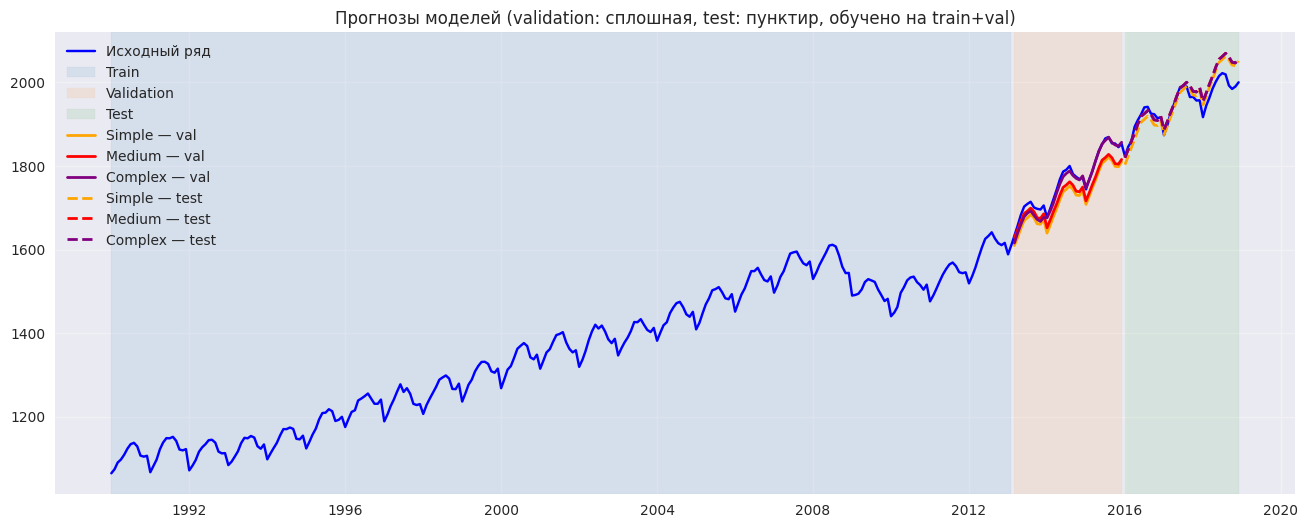

In [33]:
# Ячейка 8: финальный прогноз на test (train+validation)

train_full = pd.concat([train, validation]).copy()
train_full['ma12_trend'] = train_full['Employees'].rolling(12, min_periods=1).mean()
last_n = min(12, len(train_full))
last_vals = train_full['ma12_trend'].iloc[-last_n:].values
last_idx = train_full['Month_num'].iloc[-last_n:].values
slope = np.polyfit(last_idx, last_vals, 1)[0] if len(last_vals) >= 2 else 0
last_ma = train_full['ma12_trend'].iloc[-1]

test['ma12_trend_full'] = last_ma + slope * (test['Month_num'] - train_full['Month_num'].iloc[-1])
train_full['resid_temp'] = train_full['Employees'] - train_full['ma12_trend']
seasonal_profile_full = train_full['resid_temp'].groupby(train_full.index.month).mean().reindex(range(1,13)).fillna(0)
test['seasonal_full'] = test.index.month.map(seasonal_profile_full)

train_full['residuals'] = train_full['Employees'] - train_full['ma12_trend'] - train_full.index.month.map(seasonal_profile_full)
resid_train_full = train_full['residuals'].dropna()
ar_full = ARIMA(resid_train_full, order=(2,0,0)).fit()
resid_forecast_test_full = ar_full.forecast(steps=len(test))
resid_forecast_test_full.index = test.index

test['pred_simple_final'] = test['ma12_trend_full'] + test['seasonal_full']
test['pred_medium_final'] = test['ma12_trend_full'] + test['seasonal_full'] + resid_forecast_test_full
test['pred_complex_final'] = test['pred_medium_final']  # пока то же

# визуализация итогового прогноза
plt.figure(figsize=(16,6))
plt.plot(df_plot.index, df_plot['Employees'], color='blue', label='Исходный ряд')
plt.axvspan(train.index[0], train.index[-1], alpha=0.1, color='tab:blue', label='Train')
plt.axvspan(validation.index[0], validation.index[-1], alpha=0.1, color='tab:orange', label='Validation')
plt.axvspan(test.index[0], test.index[-1], alpha=0.1, color='tab:green', label='Test')

plt.plot(validation.index, validation['pred_simple'], color='orange', linewidth=2, label='Simple — val')
plt.plot(validation.index, validation['pred_medium'], color='red', linewidth=2, label='Medium — val')
plt.plot(validation.index, validation['pred_complex'], color='purple', linewidth=2, label='Complex — val')

plt.plot(test.index, test['pred_simple_final'], '--', color='orange', linewidth=2, label='Simple — test')
plt.plot(test.index, test['pred_medium_final'], '--', color='red', linewidth=2, label='Medium — test')
plt.plot(test.index, test['pred_complex_final'], '--', color='purple', linewidth=2, label='Complex — test')

plt.title("Прогнозы моделей (validation: сплошная, test: пунктир, обучено на train+val)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Столбцы test: ['Employees', 'Month_num', 'ma12_trend', 'seasonal', 'ma12_trend_full', 'seasonal_full', 'pred_simple_final', 'pred_medium_final', 'pred_complex_final']
NaN в medium_final: 0


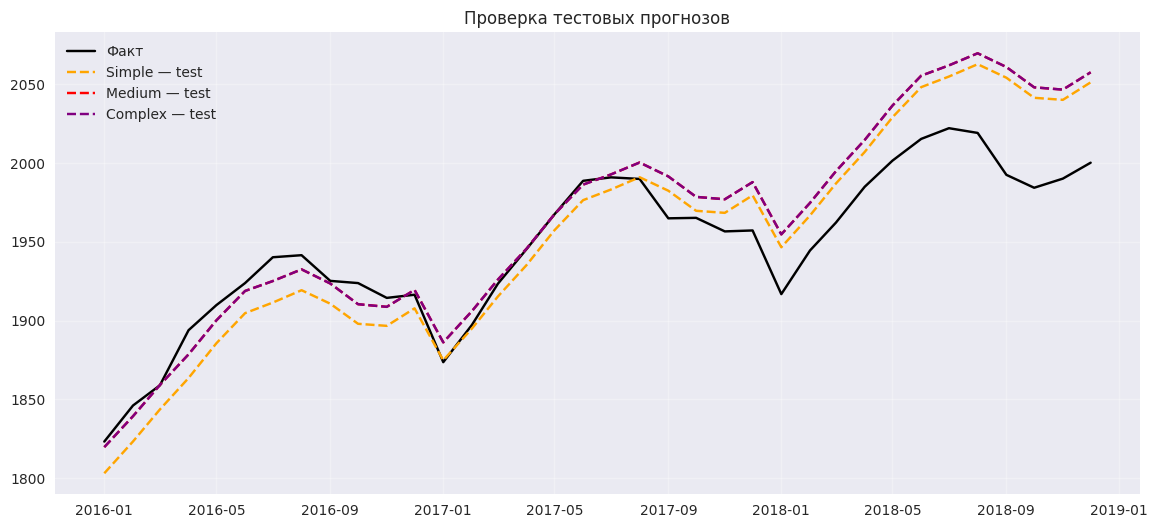

In [38]:
print("Столбцы test:", list(test.columns))
print("NaN в medium_final:", test['pred_medium_final'].isna().sum())

plt.figure(figsize=(14,6))
plt.plot(test.index, test['Employees'], color='black', label='Факт')
if 'pred_simple_final' in test.columns:
    plt.plot(test.index, test['pred_simple_final'], '--', color='orange', label='Simple — test')
if 'pred_medium_final' in test.columns:
    plt.plot(test.index, test['pred_medium_final'], '--', color='red', label='Medium — test')
if 'pred_complex_final' in test.columns:
    plt.plot(test.index, test['pred_complex_final'], '--', color='purple', label='Complex — test')

plt.legend()
plt.title("Проверка тестовых прогнозов")
plt.grid(alpha=0.3)
plt.show()


In [39]:
np.allclose(test['pred_medium_final'], test['pred_complex_final'], equal_nan=True)


True

## Финальная таблица метрик

In [40]:
# Ячейка 9: итоговые метрики
def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

rows = []
for m in ['simple', 'medium', 'complex']:
    rmse_v, mae_v, r2_v = metrics(validation['Employees'], validation[f'pred_{m}'])
    col_test = f'pred_{m}_final'
    if col_test in test.columns:
        rmse_t, mae_t, r2_t = metrics(test['Employees'], test[col_test])
    else:
        rmse_t = mae_t = r2_t = np.nan
    rows.append({
        'Model': m.capitalize(),
        'RMSE_val': rmse_v, 'MAE_val': mae_v, 'R2_val': r2_v,
        'RMSE_test': rmse_t, 'MAE_test': mae_t, 'R2_test': r2_t
    })

results_df = pd.DataFrame(rows).set_index('Model')
print("📊 Итоговые метрики моделей:")
display(results_df.round(3))


📊 Итоговые метрики моделей:


,RMSE_val,MAE_val,R2_val,RMSE_test,MAE_test,R2_test
Model,,,,,,
Simple,40.708,39.982,0.615,27.146,22.611,0.690
Medium,30.989,29.030,0.777,28.888,21.119,0.649
Complex,13.396,9.800,0.958,28.888,21.119,0.649
